In [9]:
import pandas as pd
import os
import shutil

from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [3]:
df = pd.read_csv('/Users/prajwal/Developer/Prep/Deep_Learning/Kartik/Data/train.csv')

In [4]:
diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [5]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [6]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [7]:
# Copy images to respective working directory
src_dir = '/Users/prajwal/Developer/Prep/Deep_Learning/Kartik/Data/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [8]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:
batch_size = 32

In [13]:
train_batches = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=batch_size, class_mode='categorical', shuffle=True)

Found 2562 images belonging to 2 classes.


In [14]:
val_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path, target_size=(224, 224), shuffle=True)
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path, target_size=(224, 224), shuffle=False)

Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [15]:
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [18]:
def lr_schedule(epoch):
    return 1e-5 * (0.9 ** epoch)

In [22]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [20]:
model.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches,
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/30
81/81 [==============================] - 948s 12s/step - loss: 0.4830 - accuracy: 0.7732 - val_loss: 0.2803 - val_accuracy: 0.8927 - lr: 1.0000e-05
Epoch 2/30
81/81 [==============================] - 918s 11s/step - loss: 0.3422 - accuracy: 0.8673 - val_loss: 0.2557 - val_accuracy: 0.9000 - lr: 9.0000e-06
Epoch 3/30
81/81 [==============================] - 850s 11s/step - loss: 0.3227 - accuracy: 0.8767 - val_loss: 0.2446 - val_accuracy: 0.9000 - lr: 8.1000e-06
Epoch 4/30
81/81 [==============================] - 781s 10s/step - loss: 0.3117 - accuracy: 0.8810 - val_loss: 0.2373 - val_accuracy: 0.9055 - lr: 7.2900e-06
Epoch 5/30
81/81 [==============================] - 738s 9s/step - loss: 0.2940 - accuracy: 0.8927 - val_loss: 0.2426 - val_accuracy: 0.9000 - lr: 6.5610e-06
Epoch 6/30
81/81 [==============================] - 718s 9s/step - loss: 0.2864 - accuracy: 0.8950 - val_loss: 0.2240 - val_accuracy: 0.8982 - lr: 5.9049e-06
Epoch 7/30
81/81 [==============================

In [24]:
loss, acc = model.evaluate(test_batches, verbose=1)
print("Test Accuracy: ", acc)

18/18 [==============================] - 127s 7s/step - loss: 0.2447 - accuracy: 0.9055
Test Accuracy:  0.9054545164108276


In [25]:
# Save the model
model.save('VGG16_Transfer_Learning.model')

INFO:tensorflow:Assets written to: VGG16_Transfer_Learning.model/assets


INFO:tensorflow:Assets written to: VGG16_Transfer_Learning.model/assets


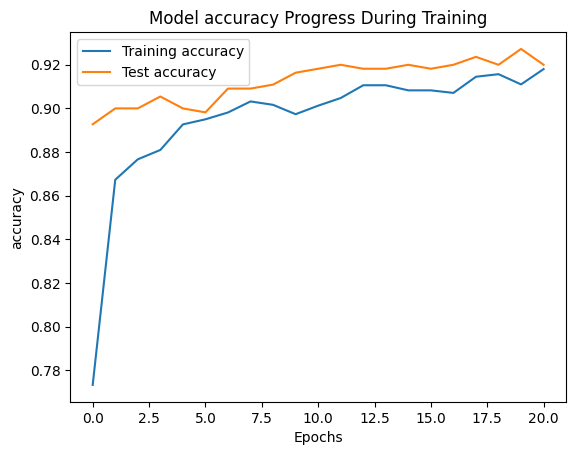

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy Progress During Training')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.show()

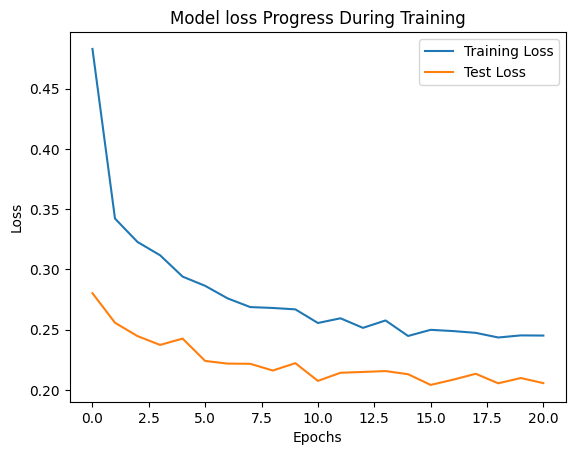

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Progress During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Test Loss'])
plt.show()